This is python code for my bachelor's thesis. 

Data about finantial instruments were dowloaded via Refinitive Eikon software, thus they are subject to copyright and we cannot provide themHowever, we will at least provide the headers of the excel documents

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

Read and prepare the data

In [2]:
# Finantial data
data = pd.read_excel('D:/bakalarka/kod/Datastream.xlsx')
data.columns
data.rename(columns={
    'Name': 'Date',
    'PRAGUE SE PX - TOT RETURN IND': 'PX',
    'STOXX EUROPE 600 E - TOT RETURN IND': 'STOXX',
    'S&P 500 COMPOSITE - TOT RETURN IND': 'SPX',
    'CZECH REPUBLIC REPO 2 WEEKS - MIDDLE RATE': 'REPO2W',
    'RFV CZECH KORUNA 2M DEPOSIT - MIDDLE RATE': 'DEPO2M',
    'CZECH TREASURY BILL 91D - RED. YIELD': 'TBILL',
    'CZECH KORUNA TO US $ (RFV) - EXCHANGE RATE': 'CZKUSD',
    'CZECH KORUNA TO EURO (WMR) - EXCHANGE RATE': 'CZKEUR'
}, inplace=True)
data['SPXCZK']=data['SPX']*data['CZKUSD']
data['STOXXCZK']=data['STOXX']*data['CZKEUR']

# Average monthly wages
data_amw = pd.read_excel('D:/bakalarka/kod/Monthly average wages.xlsx')
data_amw.rename(columns={'Name': 'Date',
                         'CZ AVERAGE MONTHLY WAGES CURN': 'AMW'}, inplace=True)
data_amw['Year'] = data_amw['Date'].dt.year

# Average monthly wages grouped by year
data_amw = data_amw.groupby('Year')['AMW'].mean().reset_index()
data_amw.columns = ['Date', 'AMW']

print(data.head())

        Date       PX   STOXX      SPX  REPO2W  DEPO2M  TBILL    CZKUSD  \
0 2006-06-30  1417.66  104.68  1939.03     2.0    2.09   2.02  22.26999   
1 2006-07-03  1414.66  105.21  1954.49     2.0    2.12   2.02  22.21750   
2 2006-07-04  1402.77  105.43  1954.49     2.0    1.99   2.15  22.23000   
3 2006-07-05  1402.77  104.18  1940.55     2.0    2.07   2.15  22.42749   
4 2006-07-06  1402.77  105.15  1945.90     2.0    2.07   2.15  22.30499   

    CZKEUR        SPXCZK     STOXXCZK  
0  28.5300  43182.178710  2986.520400  
1  28.4425  43423.881575  2992.435425  
2  28.4295  43448.312700  2997.322185  
3  28.5405  43521.665719  2973.349290  
4  28.4745  43403.280041  2994.093675  


Calculation of log and simple returns

In [ ]:
index_data = data[['Date', 'PX', 'STOXX', 'SPX', 'SPXCZK', 'STOXXCZK']]
index_data.set_index('Date', inplace=True)

data.set_index('Date', inplace=True)
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data.index)

# Log returns
log_returns = np.log(index_data / index_data.shift(1))
log_returns = log_returns.dropna()
log_returns.reset_index(inplace=True)
log_returns.set_index('Date', inplace=True)
if not isinstance(log_returns.index, pd.DatetimeIndex):
    log_returns.index = pd.to_datetime(log_returns.index)

# Simple returns
simple_returns = (index_data - index_data.shift(1)) / index_data.shift(1)
simple_returns = simple_returns.dropna()
simple_returns.reset_index(inplace=True)
simple_returns.set_index('Date', inplace=True)
if not isinstance(simple_returns.index, pd.DatetimeIndex):
    simple_returns.index = pd.to_datetime(simple_returns.index)


In [4]:
#sd and expected return and sharpe

#def cov_matrix(log_returns):
#    return log_returns.cov() * 260.8

def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights) * 260.8

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

Function for weights

In [5]:
def expanding_window_sharpe(log_returns, data, max_window_years=5):
    results = []

    start_year = log_returns.index.year.min()
    end_year = log_returns.index.year.max()

    for year in range(start_year + 1, end_year + 1):
        
        window_start_year = max(start_year, year - max_window_years) # First year of our dataset or window size before current year
        window_end_year = year - 1  # End of the window is the year before the current year

        # Filtering the data and calculating covariance matrix for the window
        window_data = log_returns[(log_returns.index.year >= window_start_year) & (log_returns.index.year <= window_end_year)]

        cov_matrix = window_data.cov() * 260.8

        # Fetching the risk-free rate: try to get the first observation of REPO2W for the rebalancing year
        next_year_data = data[data.index.year == window_end_year + 1]
        if not next_year_data.empty:
            risk_free_rate = next_year_data['REPO2W'].iloc[0] / 100
        else:
            # Fallback to the last available REPO2W rate of the current window end year if next year data is missing
            last_available_rate = data[data.index.year == window_end_year]['REPO2W'].iloc[-1] / 100
            risk_free_rate = last_available_rate

        # Optimization setup
        constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
        bounds = [(0, 1) for _ in range(len(window_data.columns))]
        initial_weights = np.array([1/len(window_data.columns)] * len(window_data.columns))
        
        optimized_result = minimize(
            neg_sharpe_ratio,
            initial_weights,
            args=(window_data, cov_matrix, risk_free_rate),
            method='SLSQP',
            constraints=constraints,
            bounds=bounds
        )

        results.append({
            'year': year,
            'optimized_weights': optimized_result.x,
            'sharpe_ratio': -optimized_result.fun  # Negating since we minimized the negative Sharpe Ratio
        })

    return results

#def risk_free_func(next_year_data):
#   risk_free_rate = next_year_data['REPO2W'].iloc[0] / 100

# Usage
#selected_log_returns = log_returns[['SPXCZK', 'STOXXCZK', 'PX']]
#selected_log_returns = log_returns[['SPX', 'STOXX', 'PX']]
#selected_cov_matrix = selected_log_returns.cov() * 260.8

#optimized_results_over_years = expanding_window_sharpe(selected_log_returns, max_window_years=3)

**Select returns in index currency or in CZK**

This is important for the rest of the code. 
After creating graphs and tables for index currency returns come back, uncomment first row, comment second and rerun cells for returns in home currency.

In [14]:
#selected_log_returns = log_returns[['SPXCZK', 'STOXXCZK', 'PX']]
selected_log_returns = log_returns[['SPX', 'STOXX', 'PX']]

#selected_simple_returns = simple_returns[['SPXCZK', 'STOXXCZK', 'PX']]
selected_simple_returns = simple_returns[['SPX', 'STOXX', 'PX']]

Correlation matrices

In [37]:
# Sample start and end dates for each period
periods = [
    (pd.to_datetime('2006-07-03'), pd.to_datetime('2012-07-02')),
    (pd.to_datetime('2012-07-03'), pd.to_datetime('2018-07-02')),
    (pd.to_datetime('2018-07-03'), pd.to_datetime('2024-07-01'))
]

# Dictionary to hold the correlation matrices
correlation_matrices = {}

# Loop through each period and calculate correlation matrices
for i, (start, end) in enumerate(periods):
    # Slice the DataFrame for the current period
    period_data = selected_log_returns[start:end]

    # Calculate the correlation matrix for the current period
    correlation_matrix = period_data.corr()
    
    # Store the correlation matrix with a label for the period
    correlation_matrices[f"Correlation Matrix {i+1} (from {start.date()} to {end.date()})"] = correlation_matrix

for label, matrix in correlation_matrices.items():
    print(label + ":")
    print(matrix)
    print() 


Correlation Matrix 1 (from 2006-07-03 to 2012-07-02):
            SPXCZK  STOXXCZK        PX
SPXCZK    1.000000  0.522626  0.233560
STOXXCZK  0.522626  1.000000  0.641295
PX        0.233560  0.641295  1.000000

Correlation Matrix 2 (from 2012-07-03 to 2018-07-02):
            SPXCZK  STOXXCZK        PX
SPXCZK    1.000000  0.593362  0.298375
STOXXCZK  0.593362  1.000000  0.591472
PX        0.298375  0.591472  1.000000

Correlation Matrix 3 (from 2018-07-03 to 2024-07-01):
            SPXCZK  STOXXCZK        PX
SPXCZK    1.000000  0.539906  0.290616
STOXXCZK  0.539906  1.000000  0.565119
PX        0.290616  0.565119  1.000000



This is just to convert correlation matrices to LaTex

In [ ]:
def dataframe_to_latex(df, caption="Correlation Matrix", label="tab:correlation", index_label="Asset"):
    """
    Convert a pandas DataFrame to a LaTeX table.
    
    Parameters:
        df (DataFrame): The DataFrame to convert.
        caption (str): The caption for the LaTeX table.
        label (str): The label used for referencing the table.
        index_label (str): The label for the DataFrame index column.
    
    Returns:
        str: A string containing the LaTeX table code.
    """
    # Start the table and tabular environment
    latex_str = f"\\begin{{table}}[!htbp]\n\\begin{{center}}\n\t\\caption{{{caption}}}\label{{{label}}}\n"
    latex_str += "\\begin{tabular}{" + "l" + "r" * len(df.columns) + "}\n\\toprule\n"
    
    # Column headers
    column_headers = " & ".join([f"$\\textit{{{index_label}}}$"] + [f"${col}$" for col in df.columns]) + " \\\\\n"
    latex_str += column_headers + "\\midrule\n"
    
    # Rows
    for index, row in df.iterrows():
        row_str = f"{index} & " + " & ".join([f"{value:.2f}" for value in row]) + " \\\\\n"
        latex_str += row_str
    
    # End the tabular environment
    latex_str += "\\bottomrule\n\\end{tabular}\n\\end{center}\n\\end{table}"
    
    return latex_str
# Assuming 'correlation_matrices' is your dictionary of matrices
for i, (label, matrix) in enumerate(correlation_matrices.items(), 1):
    latex_code = dataframe_to_latex(matrix, caption=f"Correlation Matrix for Period {i}", label=f"tab:correlation_{i}")
    print(latex_code)
    print("\n" + "="*50 + "\n")  # Print a separator between matrices

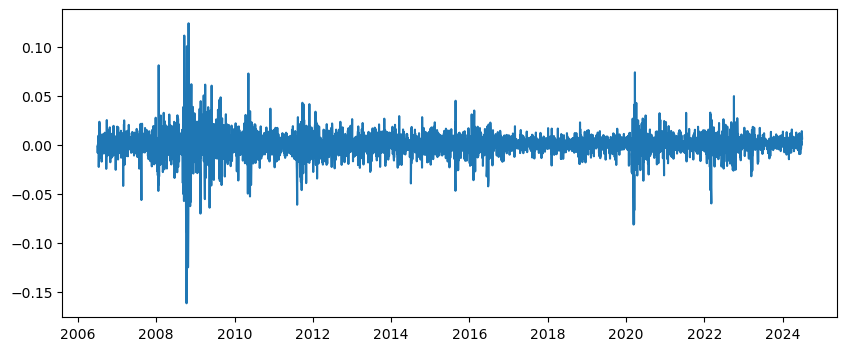

In [39]:
plt.figure(figsize=(10, 4))
plt.plot(selected_log_returns.index, selected_log_returns['PX'], label=f'PX')


Expexted returns and standart deviations

In [25]:
# Group the data by year
annual_data = selected_log_returns.groupby(selected_log_returns.index.year)
#annual_data = selected_simple_returns.groupby(selected_simple_returns.index.year)
# Calculate annual mean and standard deviation for each asset
annual_means2 = annual_data.mean() * 260.8
#annual_means = annual_means.rename(columns={'SPXCZK': 'S&P 500', 'STOXXCZK': 'STOXX 600'})
annual_means2 = annual_means2.rename(columns={'SPX': 'S&P 500', 'STOXX': 'STOXX 600'})

annual_stds2 = annual_data.std() * np.sqrt(260.8)
#annual_stds = annual_stds.rename(columns={'SPXCZK': 'S&P 500', 'STOXXCZK': 'STOXX 600'})
annual_stds2 = annual_stds2.rename(columns={'SPX': 'S&P 500', 'STOXX': 'STOXX 600'})

annual_vars2 = annual_stds2 ** 2

# Calculate covariances and correlations
annual_covs2 = annual_data.cov() * 260.8  # annualize the covariances
annual_covs2 = annual_covs2.rename(columns={'SPX': 'S&P 500', 'STOXX': 'STOXX 600'})
#annual_covs = annual_covs.rename(columns={'SPXCZK': 'S&P 500', 'STOXXCZK': 'STOXX 600'})

annual_corrs = annual_data.corr()  # correlation does not need to be annualized
#annual_corrs = annual_corrs.rename(columns={'SPX': 'S&P 500', 'STOXX': 'STOXX 600'})
annual_corrs = annual_corrs.rename(columns={'SPXCZK': 'S&P 500', 'STOXXCZK': 'STOXX 600'})



In [26]:
#annual_stats_data = pd.merge(annual_means.reset_index(), annual_means2.reset_index(), on='Date', suffixes=('_MeanCZK', '_Mean'))
annual_stats_data = annual_stats_data.merge(annual_means2, left_on='Date', right_on='Date', how='left', suffixes=('', '_Meanlog'))
annual_stats_data = annual_stats_data.merge(annual_vars2, left_on='Date', right_on='Date', how='left', suffixes=('', '_varlog'))
annual_stats_path = 'D:\\bakalarka\\kod\\annual_stats_data.xlsx'
# Save to Excel
annual_stats_data.to_excel(annual_stats_path, index=False) 


In [12]:
print(flat_covs.head())
print(flat_corrs.head())

                S&P 500  STOXX 600        PX
Date                                        
2006 SPXCZK    0.011922   0.005970  0.002807
     STOXXCZK  0.005970   0.010931  0.007890
     PX        0.002807   0.007890  0.020868
2007 SPXCZK    0.028464   0.016531  0.008976
     STOXXCZK  0.016531   0.028889  0.020100
       S&P 500  STOXX 600        PX
Date                               
2006  0.109188   0.104551  0.144457
2007  0.168713   0.169967  0.168736
2008  0.403063   0.358414  0.478932
2009  0.217455   0.210810  0.311132
2010  0.162583   0.173746  0.217093


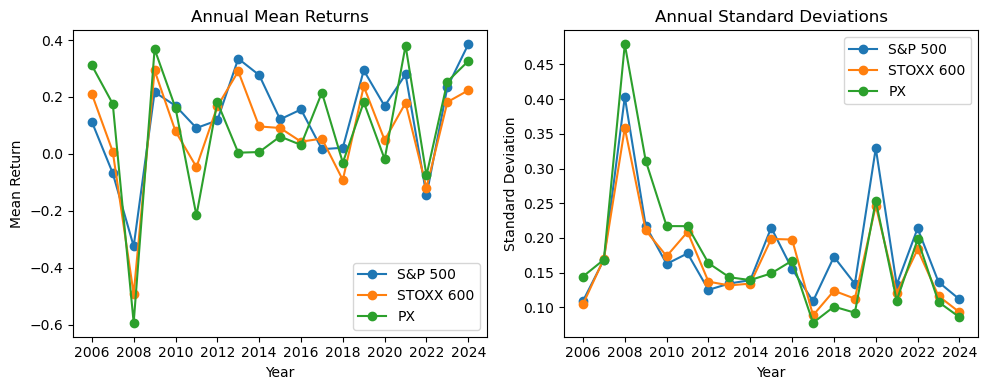

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 4))

# Plot expected returns
plt.subplot(1, 2, 1)
for column in annual_means.columns:
    plt.plot(annual_means.index, annual_means[column], marker='o', label=f'{column}')
plt.title('Annual Mean Returns')
plt.xlabel('Year')
plt.ylabel('Mean Return')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Ensures only integers are used on x-axis
plt.legend()

# Plot standard deviations
plt.subplot(1, 2, 2)
for column in annual_stds.columns:
    plt.plot(annual_stds.index, annual_stds[column], marker='o', label=f'{column}')
plt.title('Annual Standard Deviations')
plt.xlabel('Year')
plt.ylabel('Standard Deviation')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Ensures only integers are used on x-axis
plt.legend()

plt.tight_layout()
plt.show()



**Dataframe for weights**

You have to change column names to czk in second run!!!

In [ ]:
# Define window sizes to evaluate
window_sizes = [3, 4, 5, 6, 7, 8, 18]
all_weights = []
years_list = []  # To store years

# Calculate portfolio weights for each window size
for window_size in window_sizes:
    results = expanding_window_sharpe(selected_log_returns, data, max_window_years=window_size)
    weights_by_year = [result['optimized_weights'] for result in results]
    years = [result['year'] for result in results]  # Collecting years from results
    all_weights.append(weights_by_year)
    years_list.append(years)  # Assuming all window sizes cover roughly the same years, which might need verification

# Check if all elements of years_list are identical
if all(years_list[0] == x for x in years_list[1:]):
    years = years_list[0]  # All lists are the same, take one of them
else:
    raise ValueError("Years differ between window sizes; check the output.")

# Create a DataFrame with window sizes as column names
#weights_time_series = pd.DataFrame(dict(zip([f"{size}_yr_window" for size in window_sizes], all_weights)), index=years)
weights_time_series = pd.DataFrame(dict(zip([f"{size}_yr_window_czk" for size in window_sizes], all_weights)), index=years)

# Resetting the index to turn the year into a column
weights_time_series.reset_index(inplace=True)
weights_time_series.rename(columns={'index': 'Year'}, inplace=True)

print(weights_time_series.head())

Graphs of weights

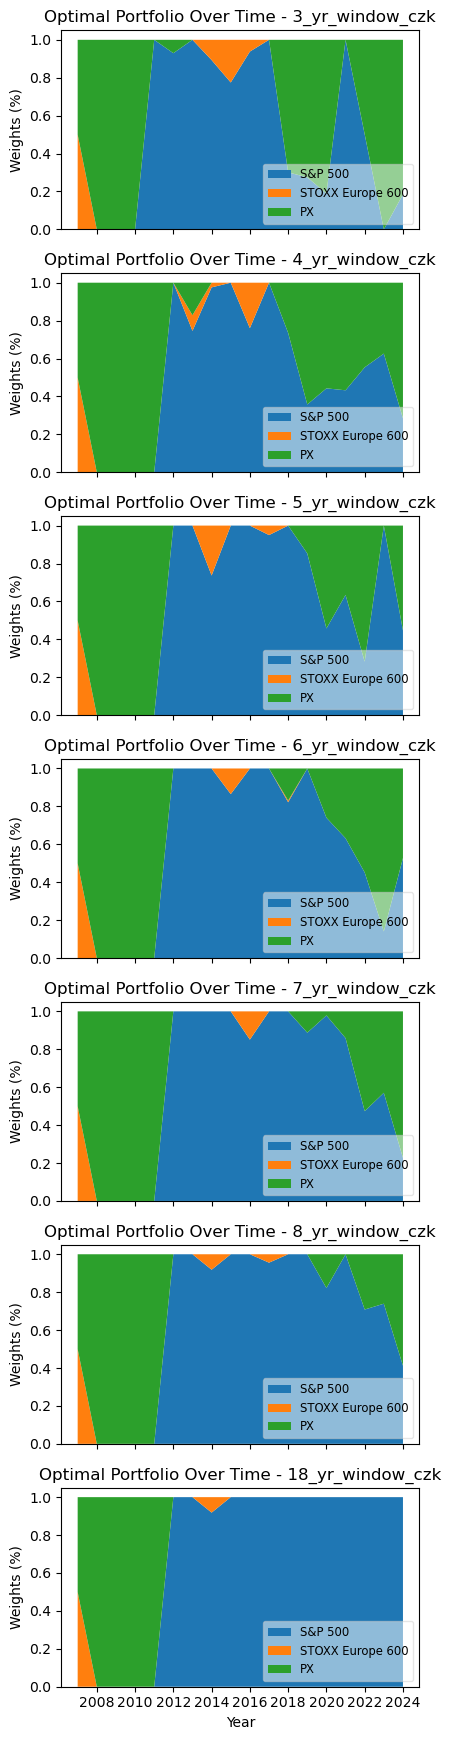

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

# Define asset names generally; update this if your data structure changes or becomes dynamic
asset_names = ['S&P 500', 'STOXX Europe 600', 'PX']
#asset_names = ['SPX', 'STOXX', 'PX']

# Create a figure and axis objects with subplots
fig, axs = plt.subplots(len(weights_time_series.columns) - 1, 1, figsize=(4.5, 2.5 * (len(weights_time_series.columns) - 1)), sharex=True)
if len(weights_time_series.columns) == 1:
    axs = [axs]  # make it iterable if it's a single subplot

# Adjusting the iterator to skip the first column which contains the year
for ax, (column_name, weights_by_year) in zip(axs, weights_time_series.iloc[:, 1:].iteritems()):
    # Since data are in arrays, no need to check type or convert
    weights_df = pd.DataFrame(weights_by_year.tolist(), index=weights_time_series['Year'], columns=asset_names)

    # Plotting the stacked area chart for each window size
    ax.stackplot(weights_df.index, weights_df.T, labels=weights_df.columns)
    ax.legend(loc='lower right', fontsize='small', frameon=True, fancybox=True, framealpha=0.5)
    ax.set_ylabel('Weights (%)')
    ax.set_title(f'Optimal Portfolio Over Time - {column_name}')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Set common labels
plt.xlabel('Year')
plt.tight_layout()
plt.show()



Creating dataframe for wealth time series

In [ ]:
simple_returns['Year'] = simple_returns.index.year
if 'Year' not in weights_time_series.columns:
    weights_time_series.reset_index(inplace=True)
# Convert index to column to keep the date information
simple_returns['Date'] = simple_returns.index
# Filter log_returns for years 2007 onward and select specific columns, including Date
czk_simple_returns = simple_returns[simple_returns.index.year >= 2007][['Date', 'Year', 'PX', 'SPXCZK', 'STOXXCZK']]

# Merge the DataFrames based on the 'Year' column
model_data = pd.merge(czk_simple_returns, weights_time_series, on='Year', how='left')
# Ensure the data is sorted by date
model_data.sort_values(by='Date', inplace=True)

# Group by year and month, then take the first entry of each group
model_data['First_Trading_Day'] = model_data.groupby([model_data['Date'].dt.year, model_data['Date'].dt.month])['Date'].transform('first')
model_data['Month_Start'] = (model_data['Date'] == model_data['First_Trading_Day']).astype(int)
# Display the first few rows of the updated DataFrame to verify the new column
print(model_data.head())


Create weights for other portfoli strategies

In [50]:
# Adding an equal-weighted portfolio column
model_data['Equal_Weighted'] = [np.array([1/3, 1/3, 1/3]) for _ in range(len(model_data))]

# Adding columns for each asset being the only investment
model_data['SPXCZK_Only'] = [np.array([1, 0, 0]) for _ in range(len(model_data))]
model_data['STOXXCZK_Only'] = [np.array([0, 1, 0]) for _ in range(len(model_data))]
model_data['PX_Only'] = [np.array([0, 0, 1]) for _ in range(len(model_data))]



Merging average monthly wage data

In [ ]:
# Ensure 'Date' is a column and filter the DataFrame for years 2007 onwards
data_amw_filtered = data_amw[data_amw['Date'] >= 2007]
# Perform a left join merge with a condition
model_data = model_data.merge(data_amw_filtered, left_on='Year', right_on='Date', how='left', suffixes=('', '_amw'))

# Apply conditions to set AMW to 1 where Month_Start is not 1
model_data['AMW'] = model_data.apply(lambda x: x['AMW'] if x['Month_Start'] == 1 else 0, axis=1)

# Drop redundant columns post-merge
model_data.drop(columns=['Date_amw'], inplace=True)  # Assuming the merge created a duplicate Date column

print(model_data.head(20))

**Calculation of cumulative sum of investors' wealth**

Here you have to change the name of strategies. Also comment first 2 lines.

In [52]:
# Initialize results_data DataFrame with the Date column from model_data
results_data = pd.DataFrame()
results_data['Date'] = model_data['Date']

# List of strategies
#strategies = ['3_yr_window', '4_yr_window', '5_yr_window', '6_yr_window', '7_yr_window', '8_yr_window', '18_yr_window', 'Equal_Weighted', 'PX_Only', 'SPXCZK_Only', 'STOXXCZK_Only']
strategies = ['3_yr_window_czk', '4_yr_window_czk', '5_yr_window_czk', '6_yr_window_czk', '7_yr_window_czk', '8_yr_window_czk', '18_yr_window_czk', 'Equal_Weighted', 'PX_Only', 'SPXCZK_Only', 'STOXXCZK_Only']
# Initialize the starting wealth
initial_wealth = 0

for strategy in strategies:
    # Initialize an empty list to store the wealth for each date
    wealth = [initial_wealth]

    # Iterate through each row in model_data
    for i in range(len(model_data)):
        # Current wealth
        current_wealth = wealth[-1]

        # Current year's AMW value
        current_amw = model_data.loc[i, 'AMW']

        # Current returns for PX, SPXCZK, and STOXXCZK
        current_returns = model_data.loc[i, ['SPXCZK', 'STOXXCZK', 'PX']].values

        # Current weights for the strategy
        current_weights = model_data.loc[i, strategy]

        # Compute new wealth
        new_wealth = (current_wealth + (1/10 * current_amw)) * (1 + np.dot(current_weights, current_returns))
        
        # Append the new wealth to the list
        wealth.append(new_wealth)

    # Add the computed wealth series to the results_data DataFrame
    results_data[strategy] = wealth[1:]  # Ignore the first entry which is the initial value


Rename strategies for consistency between graphs

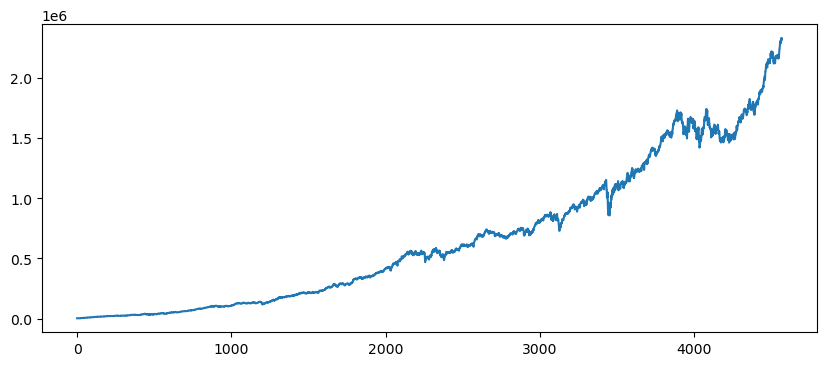

In [56]:
results_data.rename(columns={'SPXCZK_Only': 'S&P_500_Only', 'STOXXCZK_Only': 'STOXX_600_Only'}, inplace=True)

plt.figure(figsize=(10, 4))
plt.plot(results_data.index, results_data['S&P_500_Only'], label=f'S&P_500_Only')

**Graphs**

Choose betweeen strategies.

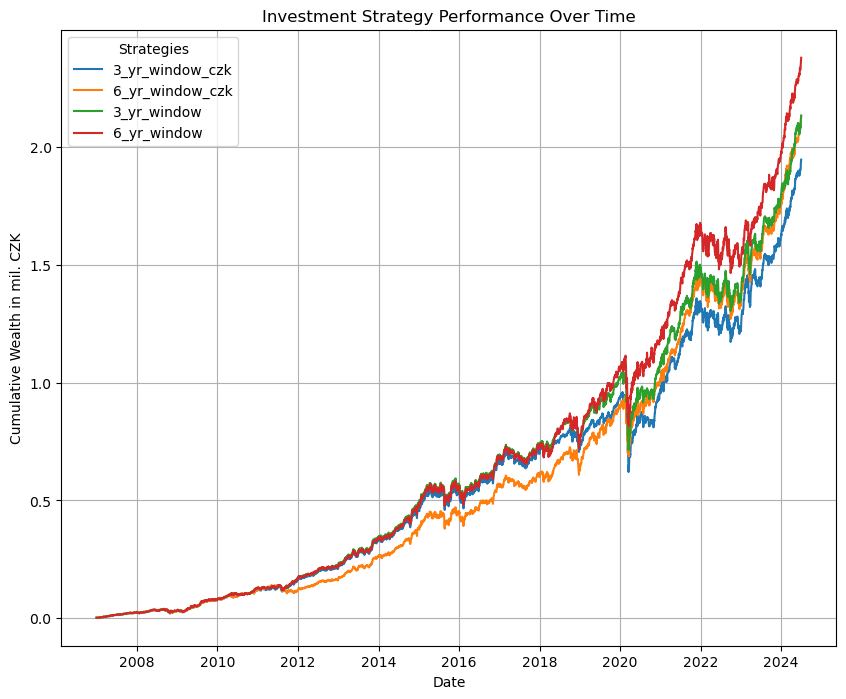

In [62]:
# Define the strategies to plot
#strategies = ['3_yr_window', '6_yr_window','8_yr_window', '18_yr_window', 'Equal_Weighted', 'PX_Only', 'S&P_500_Only', 'STOXX_600_Only']
#strategies = ['3_yr_window_czk', '6_yr_window_czk', '8_yr_window_czk', '18_yr_window_czk', 'Equal_Weighted', 'PX_Only', 'S&P_500_Only', 'STOXX_600_Only']
strategies = ['3_yr_window_czk', '6_yr_window_czk', '3_yr_window', '6_yr_window']
# Start a new figure
plt.figure(figsize=(10, 8))

# Plot each strategy
for strategy in strategies:
    plt.plot(results_data['Date'], results_data[strategy] / 1e6, label=strategy)

# Add titles and labels
plt.title('Investment Strategy Performance Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Wealth in mil. CZK')

# Add a legend
plt.legend(title='Strategies')

# Show grid
plt.grid(True)

# Show the plot
plt.show()


In [64]:
# Define the list of strategy columns to consider
strategy_columns = ['3_yr_window', '4_yr_window', '5_yr_window', '6_yr_window', '7_yr_window', '8_yr_window', '18_yr_window', '3_yr_window_czk', '4_yr_window_czk', 
                    '5_yr_window_czk', '6_yr_window_czk', '7_yr_window_czk', '8_yr_window_czk', '18_yr_window_czk', 'Equal_Weighted', 'PX_Only', 'S&P_500_Only', 'STOXX_600_Only']

# Identify the column with the maximum value for each row
max_strategy = results_data[strategy_columns].idxmax(axis=1)

# Initialize the strat_perf DataFrame with zeros
strat_perf = pd.DataFrame(0, index=results_data.index, columns=strategy_columns)

# Set the column corresponding to the max value per row to 1
for row, strategy in enumerate(max_strategy):
    strat_perf.at[row, strategy] = 1

strat_perf['Date'] = results_data['Date']

print(strat_perf.sum())

In [70]:
# Define file paths
strat_perf_path = 'D:\\bakalarka\\kod\\strat_perf.xlsx'
results_data_path = 'D:\\bakalarka\\kod\\results_data.xlsx'

# Save to Excel
strat_perf.to_excel(strat_perf_path, index=False)  # Assuming you might not need the index
results_data.to_excel(results_data_path, index=False)

**Part 2:**

*Sectoral indicies*


In [ ]:
# Finantial data
data = pd.read_excel('D:/bakalarka/kod/Datastream.xlsx')
data.columns
data.rename(columns={
    'Name': 'Date',
    'PRAGUE SE PX - TOT RETURN IND': 'PX',
    'STOXX EUROPE 600 E - TOT RETURN IND': 'STOXX',
    'S&P 500 COMPOSITE - TOT RETURN IND': 'SPX',
    'CZECH REPUBLIC REPO 2 WEEKS - MIDDLE RATE': 'REPO2W',
    'RFV CZECH KORUNA 2M DEPOSIT - MIDDLE RATE': 'DEPO2M',
    'CZECH TREASURY BILL 91D - RED. YIELD': 'TBILL',
    'CZECH KORUNA TO US $ (RFV) - EXCHANGE RATE': 'CZKUSD',
    'CZECH KORUNA TO EURO (WMR) - EXCHANGE RATE': 'CZKEUR'
}, inplace=True)
data['SPXCZK']=data['SPX']*data['CZKUSD']
data['STOXXCZK']=data['STOXX']*data['CZKEUR']

#sectoral data
data_sectors = pd.read_excel('D:/bakalarka/kod/Sectoral_indicies.xlsx')
#rename function
def shorten_name(name):
    if "S&P500" in name:
        new_name = name.replace("S&P500 ES", "S&P").split(" -")[0]
    elif "STOXX EUROPE 600" in name:
        new_name = name.replace("STOXX EUROPE 600", "STOXX").split(" E")[0]
    else:
        new_name = name
    return new_name

data_sectors.columns = [shorten_name(col) for col in data_sectors.columns]

# Add CZK-denominated columns for S&P and STOXX indices
for col in data_sectors.columns:
    if "S&P" in col:
        data_sectors[col + ' CZK'] = data_sectors[col] * data['CZKUSD']
    elif "STOXX" in col:
        data_sectors[col + ' CZK'] = data_sectors[col] * data['CZKEUR']



# Average monthly wages
data_amw = pd.read_excel('D:/bakalarka/kod/Monthly average wages.xlsx')
data_amw.rename(columns={'Name': 'Date',
                         'CZ AVERAGE MONTHLY WAGES CURN': 'AMW'}, inplace=True)
data_amw['Year'] = data_amw['Date'].dt.year

# Average monthly wages grouped by year
data_amw = data_amw.groupby('Year')['AMW'].mean().reset_index()
data_amw.columns = ['Date', 'AMW']

#print(data_ayw)
print(data.head())
#print(data.tail())
#print(data_amw.head())
#print(data_amw.tail())

In [5]:

data_sectors.set_index('Date', inplace=True)

data.set_index('Date', inplace=True)
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data.index)

# Log returns
log_returns = np.log(data_sectors / data_sectors.shift(1))
log_returns = log_returns.dropna()
log_returns.reset_index(inplace=True)
log_returns.set_index('Date', inplace=True)
if not isinstance(log_returns.index, pd.DatetimeIndex):
    log_returns.index = pd.to_datetime(log_returns.index)

# Simple returns
simple_returns = (data_sectors - data_sectors.shift(1)) / data_sectors.shift(1)
simple_returns = simple_returns.dropna()
simple_returns.reset_index(inplace=True)
simple_returns.set_index('Date', inplace=True)
if not isinstance(simple_returns.index, pd.DatetimeIndex):
    simple_returns.index = pd.to_datetime(simple_returns.index)

In [34]:
#sd and expected return and sharpe

def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights) * 260.8

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

#def custom_bounds(weights):
#   # We use a small threshold to decide if the weight is "effectively zero" or should be bound by 0.05
#   return [(0 if w < 0.1 else 0.1, 1) for w in weights]

In [35]:
def expanding_window_sharpe(log_returns, data, max_window_years=5):
    results = []

    start_year = log_returns.index.year.min()
    end_year = log_returns.index.year.max()

    for year in range(start_year + 1, end_year + 1):
        
        window_start_year = max(start_year, year - max_window_years) # First year of our dataset or window size before current year
        window_end_year = year - 1  # End of the window is the year before the current year

        # Filtering the data and calculating covariance matrix for the window
        window_data = log_returns[(log_returns.index.year >= window_start_year) & (log_returns.index.year <= window_end_year)]

        cov_matrix = window_data.cov() * 260.8

        # Fetching the risk-free rate: try to get the first observation of REPO2W for the rebalancing year
        next_year_data = data[data.index.year == window_end_year + 1]
        if not next_year_data.empty:
            risk_free_rate = next_year_data['REPO2W'].iloc[0] / 100
        else:
            # Fallback to the last available REPO2W rate of the current window end year if next year data is missing
            last_available_rate = data[data.index.year == window_end_year]['REPO2W'].iloc[-1] / 100
            risk_free_rate = last_available_rate

        # Optimization setup
        constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
        bounds = [(0, 1) for _ in range(len(window_data.columns))]
        initial_weights = np.array([1/len(window_data.columns)] * len(window_data.columns))
        
        optimized_result = minimize(
            neg_sharpe_ratio,
            initial_weights,
            args=(window_data, cov_matrix, risk_free_rate),
            method='SLSQP',
            constraints=constraints,
            bounds=bounds
        )

        results.append({
            'year': year,
            'optimized_weights': optimized_result.x,
            'sharpe_ratio': -optimized_result.fun  # Negating since we minimized the negative Sharpe Ratio
        })

    return results


In [29]:
# Identify columns that end with 'CZK'
czk_columns = [col for col in log_returns.columns if col.endswith('CZK')]
czk_columns.append('PX')

# Columns that do not end with 'CZK'
non_czk_columns = [col for col in log_returns.columns if not col.endswith('CZK')]


#selected_log_returns= log_returns[czk_columns]
selected_log_returns= log_returns[non_czk_columns]

selected_simple_returns= simple_returns[czk_columns]
#selected_simple_returns= simple_returns[non_czk_columns]

In [ ]:
# Define window sizes to evaluate
window_sizes = [3, 6, 8, 18]
all_weights = []
years_list = []  # To store years

# Calculate portfolio weights for each window size
for window_size in window_sizes:
    results = expanding_window_sharpe(selected_log_returns, data, max_window_years=window_size)
    weights_by_year = [result['optimized_weights'] for result in results]
    years = [result['year'] for result in results]  # Collecting years from results
    all_weights.append(weights_by_year)
    years_list.append(years)  # Assuming all window sizes cover roughly the same years, which might need verification

# Check if all elements of years_list are identical
if all(years_list[0] == x for x in years_list[1:]):
    years = years_list[0]  # All lists are the same, take one of them
else:
    raise ValueError("Years differ between window sizes; check the output.")

# Create a DataFrame with window sizes as column names
weights_time_series = pd.DataFrame(dict(zip([f"{size}_yr_window" for size in window_sizes], all_weights)), index=years)
#weights_time_series = pd.DataFrame(dict(zip([f"{size}_yr_window_czk" for size in window_sizes], all_weights)), index=years)

# Resetting the index to turn the year into a column
weights_time_series.reset_index(inplace=True)
weights_time_series.rename(columns={'index': 'Year'}, inplace=True)

print(weights_time_series.head())

In [ ]:

def round_weights(weight):
    # This function will round weights to three decimal places
    return np.round(weight, 3) if isinstance(weight, float) else weight

# If each cell in the DataFrame is a list of weights
for column in weights_time_series.columns:
    if column != 'Year':  # Exclude the 'Year' column
        weights_time_series[column] = weights_time_series[column].apply(lambda weights: [round_weights(w) for w in weights])

# Or if each cell is a single weight value already (seems less likely based on your description)
# weights_time_series = weights_time_series.applymap(round_weights)
print(weights_time_series.head())

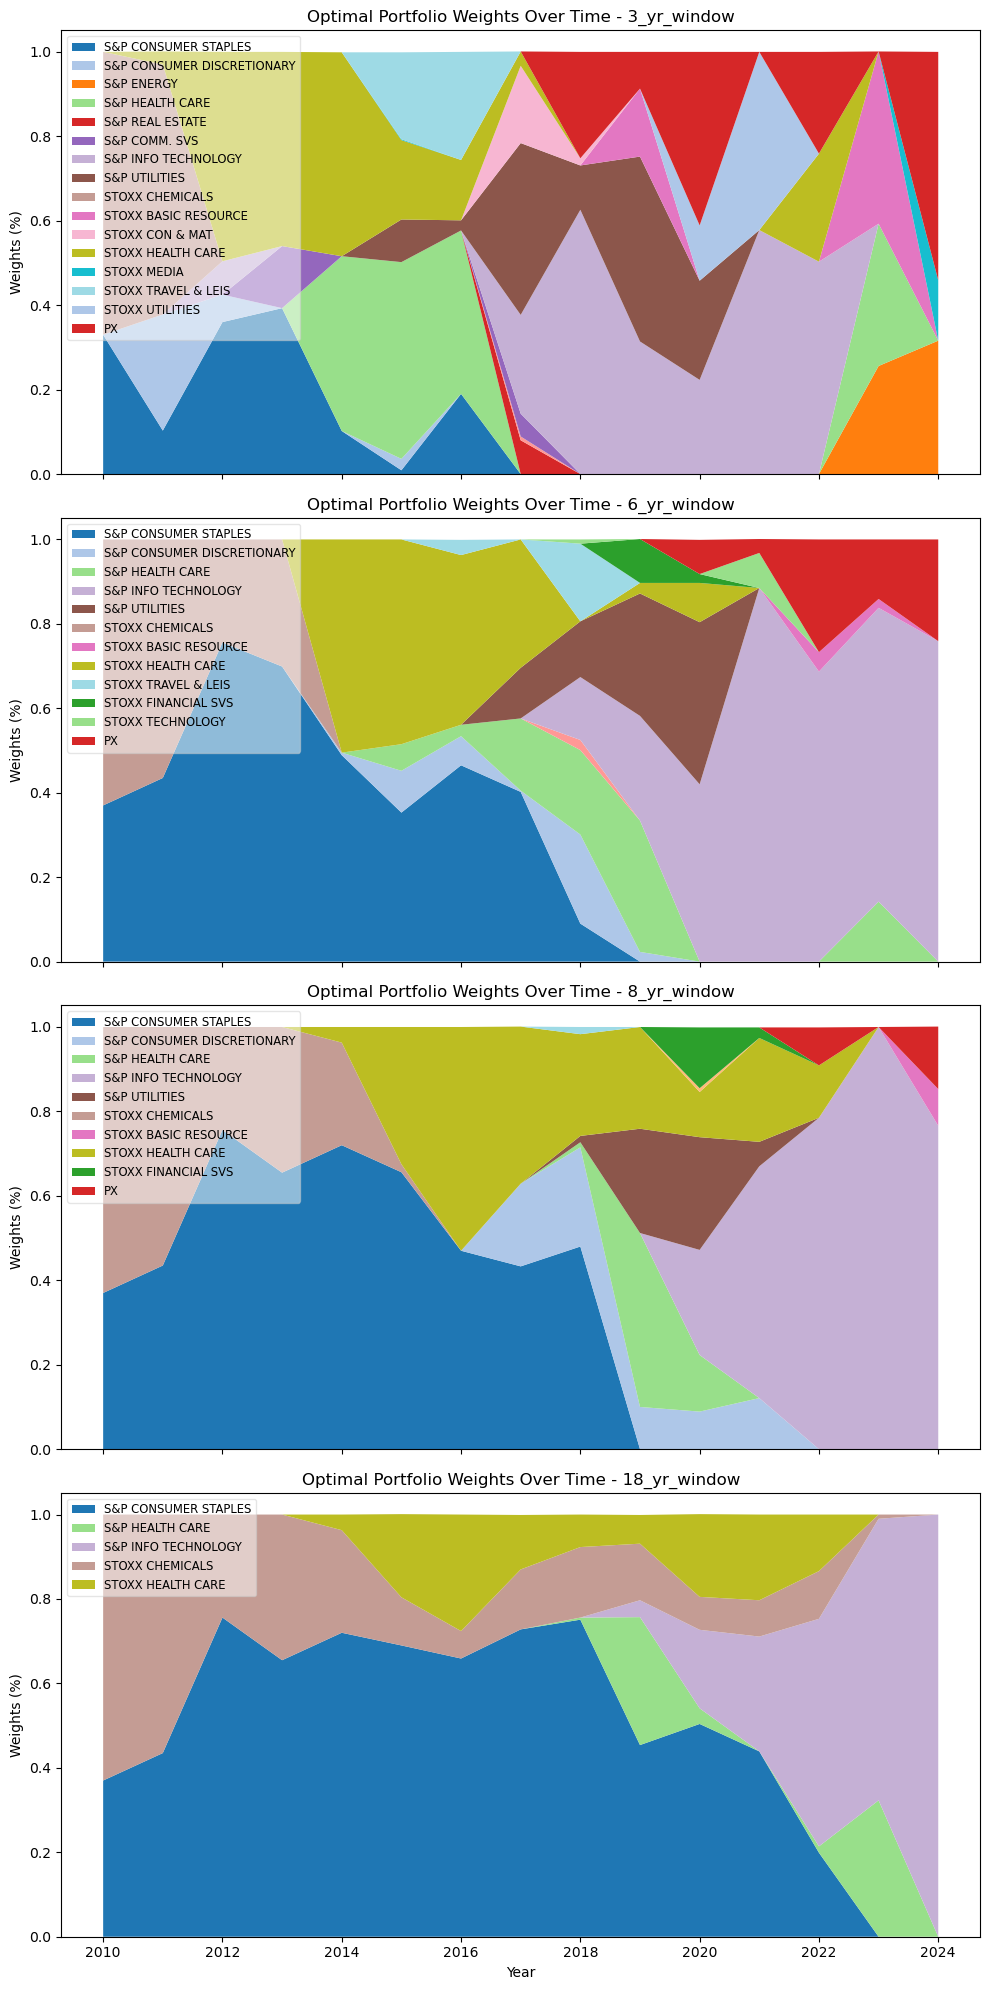

In [56]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

# Assuming asset_names and weights_time_series are already defined
asset_names = selected_log_returns.columns.tolist()
if 'Date' in asset_names:
    asset_names.remove('Date')  # Make sure 'Date' is not in the list

# Filter the DataFrame to start from 2010 onwards
filtered_weights = weights_time_series[weights_time_series['Year'] >= 2010]

# Get a color map with sufficient colors
color_map = plt.get_cmap('tab20')
colors = color_map.colors  # This gives 20 colors. Use np.repeat to cycle if more than 20 assets.

# Create a figure and axis objects with subplots
fig, axs = plt.subplots(len(filtered_weights.columns) - 1, 1, figsize=(10, 5 * (len(filtered_weights.columns) - 1)), sharex=True)
if len(filtered_weights.columns) == 1:
    axs = [axs]  # Ensure it is iterable if it's a single subplot

# Adjusting the iterator to skip the first column which is the 'Year'
for ax, (column_name, weights_by_year) in zip(axs, filtered_weights.iloc[:, 1:].iteritems()):
    # Construct DataFrame for each subplot
    weights_df = pd.DataFrame(weights_by_year.tolist(), index=filtered_weights['Year'], columns=asset_names)

    # Plotting the stacked area chart for each window size with custom colors
    stacks = ax.stackplot(weights_df.index, weights_df.T, colors=colors[:len(asset_names)])

    # Only add legend for non-zero columns
    non_zero_columns = [col for col in weights_df.columns if weights_df[col].sum() > 0.05]
    handles = [stacks[i] for i, col in enumerate(weights_df.columns) if col in non_zero_columns]
    labels = non_zero_columns
    ax.legend(handles, labels, loc='upper left', fontsize='small', frameon=True, fancybox=True, framealpha=0.5)

    ax.set_ylabel('Weights (%)')
    ax.set_title(f'Optimal Portfolio Weights Over Time - {column_name}')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.xlabel('Year')
plt.tight_layout()
plt.show()


In [57]:
#selected_simple_returns= simple_returns[czk_columns]

In [ ]:
selected_simple_returns['Year'] = selected_simple_returns.index.year
if 'Year' not in weights_time_series.columns:
    weights_time_series.reset_index(inplace=True)
# Convert index to column to keep the date information
selected_simple_returns['Date'] = selected_simple_returns.index
# Filter log_returns for years 2007 onward and select specific columns, including Date
czk_simple_returns = selected_simple_returns[selected_simple_returns.index.year >= 2007]

# Merge the DataFrames based on the 'Year' column
model_data = pd.merge(czk_simple_returns, weights_time_series, on='Year', how='left')
# Ensure the data is sorted by date
model_data.sort_values(by='Date', inplace=True)

# Group by year and month, then take the first entry of each group
model_data['First_Trading_Day'] = model_data.groupby([model_data['Date'].dt.year, model_data['Date'].dt.month])['Date'].transform('first')
model_data['Month_Start'] = (model_data['Date'] == model_data['First_Trading_Day']).astype(int)
# Display the first few rows of the updated DataFrame to verify the new column
print(model_data.head())

In [ ]:
# Ensure 'Date' is a column and filter the DataFrame for years 2007 onwards
data_amw_filtered = data_amw[data_amw['Date'] >= 2007]
# Perform a left join merge with a condition
model_data = model_data.merge(data_amw_filtered, left_on='Year', right_on='Date', how='left', suffixes=('', '_amw'))

# Apply conditions to set AMW to 1 where Month_Start is not 1
model_data['AMW'] = model_data.apply(lambda x: x['AMW'] if x['Month_Start'] == 1 else 0, axis=1)

# Drop redundant columns post-merge
model_data.drop(columns=['Date_amw'], inplace=True)  # Assuming the merge created a duplicate Date column

print(model_data.head(20))

In [61]:
results_data = pd.DataFrame()
results_data['Date'] = model_data['Date']

# List of strategies
strategies = ['3_yr_window', '6_yr_window', '8_yr_window', '18_yr_window']
# Initialize the starting wealth
initial_wealth = 0

for strategy in strategies:
    # Initialize an empty list to store the wealth for each date
    wealth = [initial_wealth]

    # Iterate through each row in model_data
    for i in range(len(model_data)):
        # Current wealth
        current_wealth = wealth[-1]

        # Current year's AMW value
        current_amw = model_data.loc[i, 'AMW']

        # Current returns for PX, SPXCZK, and STOXXCZK
        current_returns = model_data.loc[i, czk_columns].values

        # Current weights for the strategy
        current_weights = model_data.loc[i, strategy]

        # Compute new wealth
        new_wealth = (current_wealth + (1/10 * current_amw)) * (1 + np.dot(current_weights, current_returns))
        
        # Append the new wealth to the list
        wealth.append(new_wealth)

    # Add the computed wealth series to the results_data DataFrame
    results_data[strategy] = wealth[1:]  # Ignore the first entry which is the initial value

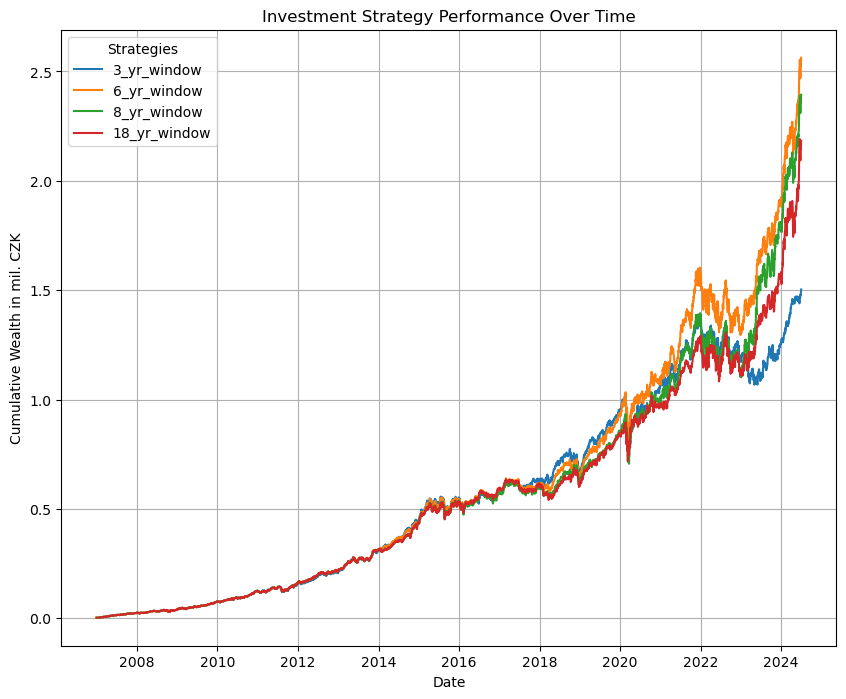

In [62]:
strategies = ['3_yr_window', '6_yr_window', '8_yr_window', '18_yr_window']
# Start a new figure
plt.figure(figsize=(10, 8))

# Plot each strategy
for strategy in strategies:
    plt.plot(results_data['Date'], results_data[strategy] / 1e6, label=strategy)

# Add titles and labels
plt.title('Investment Strategy Performance Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Wealth in mil. CZK')

# Add a legend
plt.legend(title='Strategies')

# Show grid
plt.grid(True)

# Show the plot
plt.show()